# ECG Arrhythmia Classification
 
 This notebook analyzes ECG signals and classifies different types of arrhythmias using pre-trained models.


In [1]:
# Cell 1: Setup and Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
import joblib
from collections import Counter
import seaborn as sns

# Add the parent directory to the path to import project modules
sys.path.append('..')
from src import data_processing, peak_detection, feature_extraction, arrhythmia_classifier

# Configure matplotlib
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12


Loaded ECG data with 2 channels
Duration: 1805.55 seconds
Sampling frequency: 360 Hz


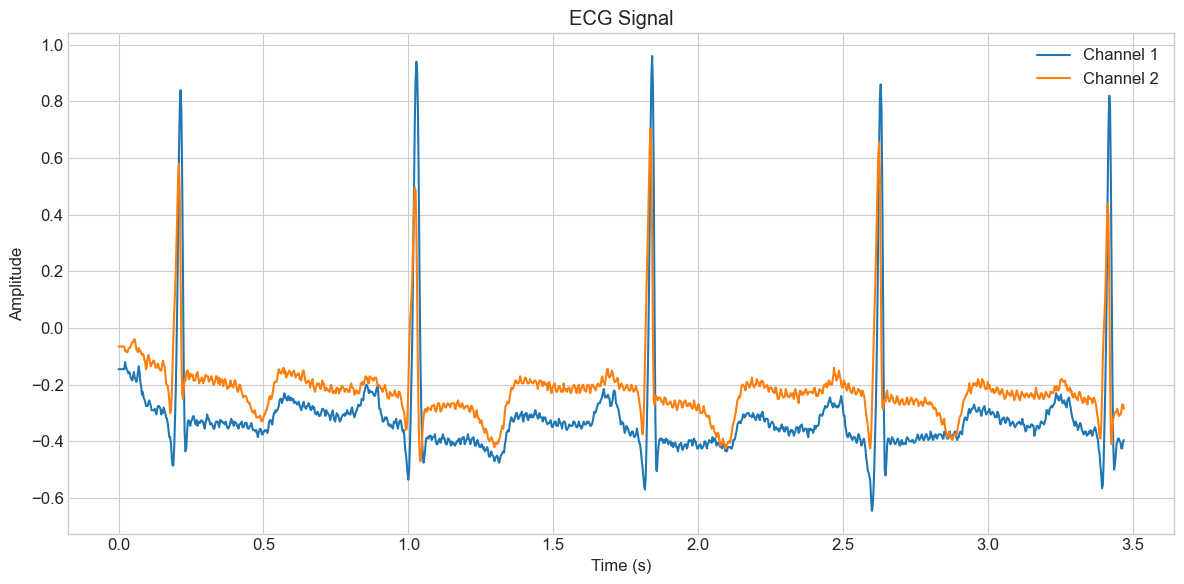

In [2]:
# %% Cell 2: Load ECG Data
def load_ecg_data(file_path):
    """Load ECG data from CSV file."""
    try:
        # Load data
        df = pd.read_csv(file_path)
        
        # Check for time column
        if 'Time (s)' in df.columns:
            time = df['Time (s)'].values
            # Calculate sampling frequency from time array
            fs = int(1 / (time[1] - time[0]))
        else:
            # Create time array based on assumed frequency
            fs = 250  # Default 250 Hz
            time = np.arange(len(df)) / fs
        
        # Detect ECG signal columns
        ecg_columns = [col for col in df.columns if col.startswith('Channel') or 
                       col.startswith('ECG') or col.startswith('Lead')]
        
        if not ecg_columns:
            # If no specific ECG columns found, use all numeric columns except time
            ecg_columns = [col for col in df.columns if col != 'Time (s)' and 
                           np.issubdtype(df[col].dtype, np.number)]
        
        # Extract ECG signal
        ecg_signal = df[ecg_columns].values
        
        print(f"Loaded ECG data with {len(ecg_columns)} channels")
        print(f"Duration: {time[-1]:.2f} seconds")
        print(f"Sampling frequency: {fs} Hz")
        
        return time, ecg_signal, fs
        
    except Exception as e:
        print(f"Error loading ECG data: {e}")
        return None, None, None

# Try to load the ECG data
file_path = '../data/processed/ecg_signal.csv'
if os.path.exists(file_path):
    time, ecg_signal, fs = load_ecg_data(file_path)
else:
    print(f"ECG data file not found: {file_path}")
    print("Generating synthetic ECG data...")
    
    # Generate synthetic ECG data
    duration = 10  # seconds
    fs = 250  # Hz
    time = np.arange(0, duration, 1/fs)
    
    # Create synthetic ECG with 12 heartbeats (approximately 72 BPM)
    ecg_signal = np.zeros((len(time), 2))  # Two channels
    
    # Create synthetic heartbeats
    for i in range(12):
        t_center = i * 0.83
        # QRS complex
        qrs_mask = (time > t_center - 0.03) & (time < t_center + 0.03)
        ecg_signal[qrs_mask, 0] = 1.5 * np.sin((time[qrs_mask] - t_center) * 150 + np.pi/2)
        ecg_signal[qrs_mask, 1] = 1.2 * np.sin((time[qrs_mask] - t_center) * 150 + np.pi/2)
        
        # P wave
        p_center = t_center - 0.15
        p_mask = (time > p_center - 0.05) & (time < p_center + 0.05)
        ecg_signal[p_mask, 0] += 0.25 * np.sin((time[p_mask] - p_center) * 100 + np.pi/2)
        ecg_signal[p_mask, 1] += 0.2 * np.sin((time[p_mask] - p_center) * 100 + np.pi/2)
        
        # T wave
        t_center = t_center + 0.2
        t_mask = (time > t_center - 0.1) & (time < t_center + 0.1)
        ecg_signal[t_mask, 0] += 0.35 * np.sin((time[t_mask] - t_center) * 50 + np.pi/2)
        ecg_signal[t_mask, 1] += 0.3 * np.sin((time[t_mask] - t_center) * 50 + np.pi/2)
    
    # Add noise
    ecg_signal[:, 0] += np.random.normal(0, 0.05, len(time))
    ecg_signal[:, 1] += np.random.normal(0, 0.04, len(time))

# Plot ECG signal
plt.figure(figsize=(12, 6))
for channel in range(min(2, ecg_signal.shape[1])):
    plt.plot(time[:1250], ecg_signal[:1250, channel], label=f'Channel {channel+1}')
plt.title('ECG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


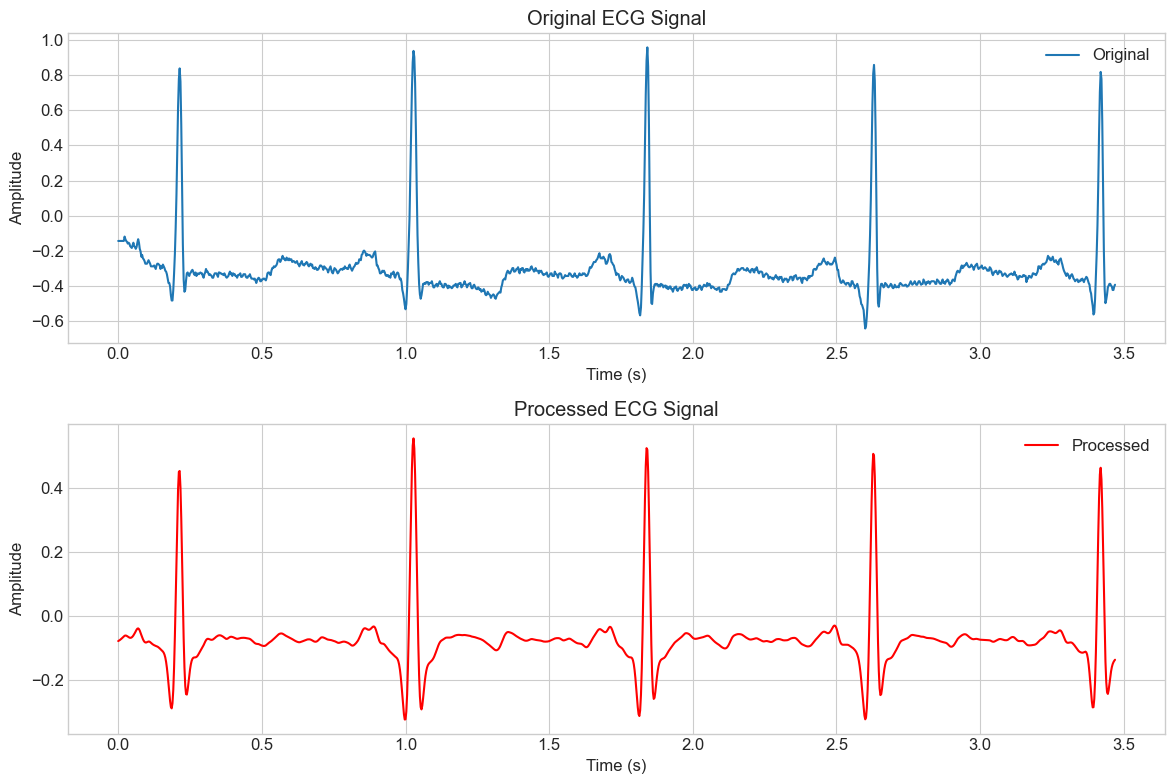

In [3]:

# %% Cell 3: Preprocess ECG Signal
# Process the ECG signal
channel_to_analyze = 0  # Use the first channel by default
processed_signal = data_processing.preprocess_ecg(ecg_signal, fs)

# Plot the original and processed signals
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(time[:1250], ecg_signal[:1250, channel_to_analyze], label='Original')
plt.title('Original ECG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(time[:1250], processed_signal[:1250, channel_to_analyze], label='Processed', color='r')
plt.title('Processed ECG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Detected 2273 R-peaks
Average heart rate: 75.5 BPM


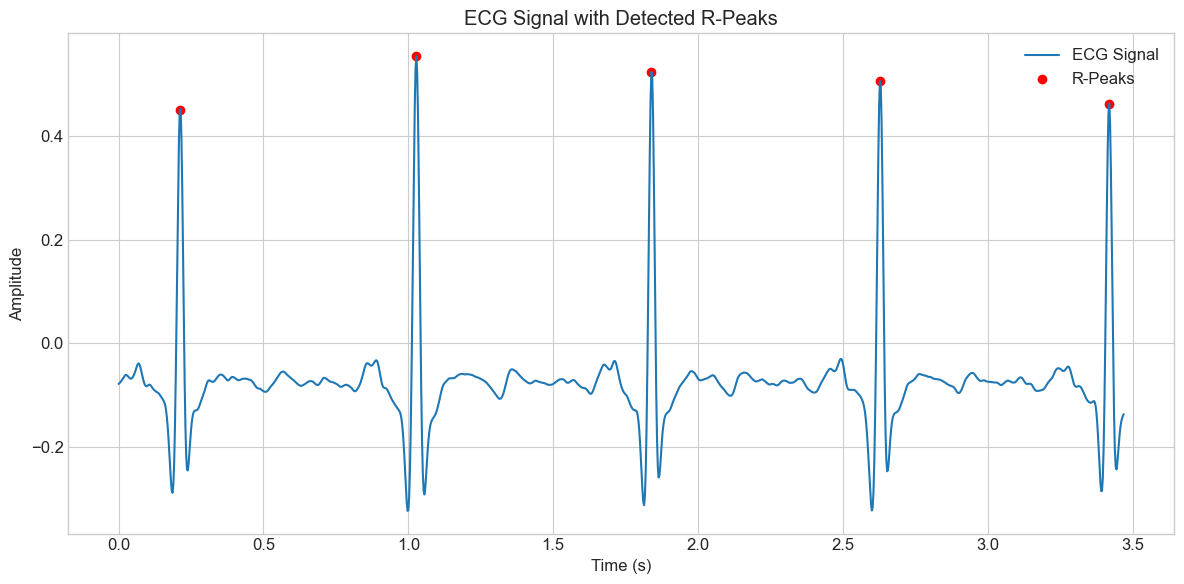

Extracted 2271 heartbeats


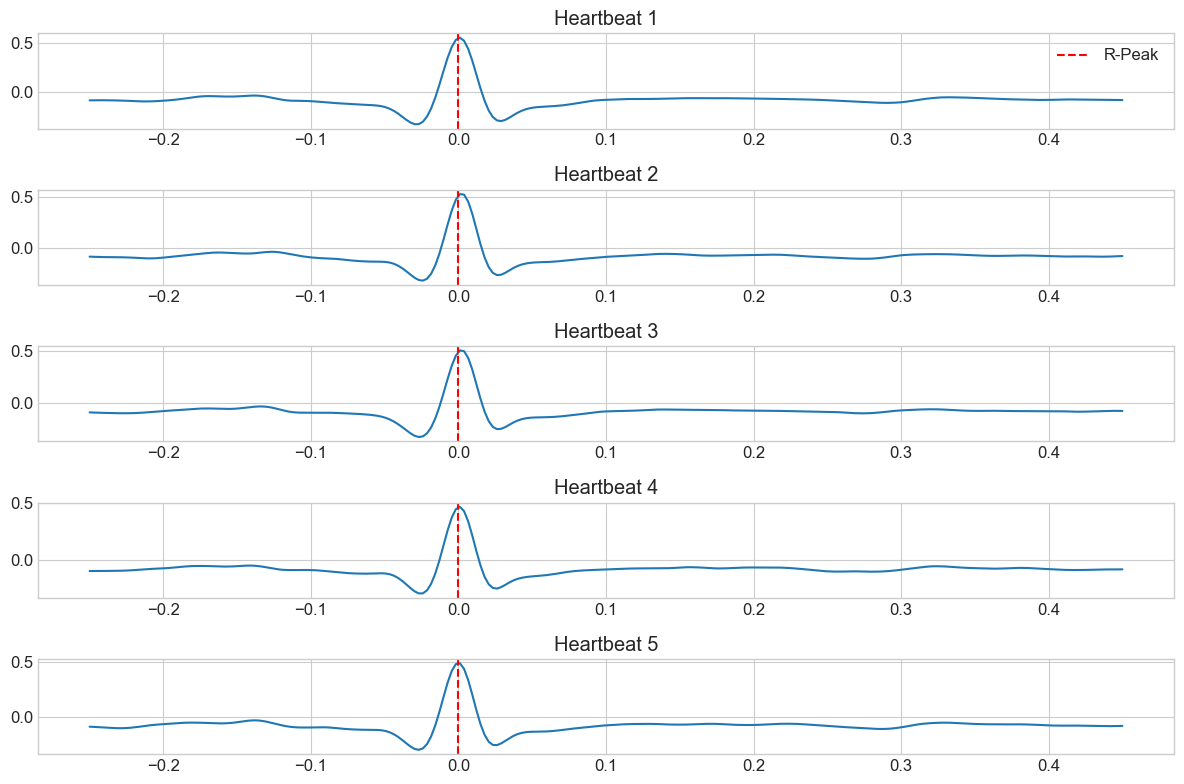

In [4]:
# %% Cell 4: Detect R-Peaks and Extract Heartbeats
# Detect R-peaks
r_peaks = peak_detection.detect_r_peaks(processed_signal[:, channel_to_analyze], fs)
print(f"Detected {len(r_peaks)} R-peaks")

# Calculate heart rate
if len(r_peaks) > 1:
    rr_intervals = np.diff(r_peaks) / fs
    heart_rate = 60 / np.mean(rr_intervals)
    print(f"Average heart rate: {heart_rate:.1f} BPM")

# Plot ECG with R-peaks
plt.figure(figsize=(12, 6))
plt.plot(time[:1250], processed_signal[:1250, channel_to_analyze], label='ECG Signal')
r_peaks_in_window = r_peaks[r_peaks < 1250]
plt.scatter(time[r_peaks_in_window], processed_signal[r_peaks_in_window, channel_to_analyze], 
           color='r', marker='o', label='R-Peaks')
plt.title('ECG Signal with Detected R-Peaks')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Extract heartbeats
heartbeats = data_processing.extract_heartbeat_segments(
    processed_signal[:, channel_to_analyze],
    r_peaks,
    fs,
    before_r=0.25,
    after_r=0.45
)
print(f"Extracted {len(heartbeats)} heartbeats")

# Plot a few example heartbeats
plt.figure(figsize=(12, 8))
num_beats = min(5, len(heartbeats))
for i in range(num_beats):
    plt.subplot(num_beats, 1, i+1)
    beat_time = np.linspace(-0.25, 0.45, heartbeats[i].shape[0])
    plt.plot(beat_time, heartbeats[i])
    plt.axvline(x=0, color='r', linestyle='--', label='R-Peak')
    plt.title(f'Heartbeat {i+1}')
    plt.grid(True)
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show()


In [5]:
# %% Cell 5: Load Arrhythmia Classification Model
# Path to saved models
models_dir = '../models/saved'

# Check if models directory exists
if not os.path.exists(models_dir):
    os.makedirs(models_dir, exist_ok=True)
    print(f"Created models directory: {models_dir}")

# Try to find available models
available_models = []
try:
    for model_name in os.listdir(models_dir):
        model_path = os.path.join(models_dir, model_name)
        if os.path.isdir(model_path) and os.path.exists(os.path.join(model_path, 'arrhythmia_classifier.pkl')):
            available_models.append(model_name)
except:
    pass

print(f"Available models: {available_models}")

# Load the best available model (ensemble > random_forest > any)
model_to_use = 'ensemble' if 'ensemble' in available_models else (
               'random_forest' if 'random_forest' in available_models else (
               available_models[0] if available_models else None))

if model_to_use:
    print(f"Using model: {model_to_use}")
    try:
        pipeline, label_names = arrhythmia_classifier.load_classifier(os.path.join(models_dir, model_to_use))
        print(f"Successfully loaded {model_to_use} model")
        print(f"Label mapping: {label_names}")
    except Exception as e:
        print(f"Error loading model: {e}")
        print("Creating a demo classifier")
        pipeline, label_names = arrhythmia_classifier.create_demo_classifier()
else:
    print("No pre-trained models found. Creating a demo classifier.")
    pipeline, label_names = arrhythmia_classifier.create_demo_classifier()
    # Save the demo classifier for future use
    model_to_use = 'demo'
    os.makedirs(os.path.join(models_dir, model_to_use), exist_ok=True)
    arrhythmia_classifier.save_classifier(pipeline, label_names, os.path.join(models_dir, model_to_use))


Available models: ['final_model', 'neural_network', 'random_forest', 'svm']
Using model: random_forest
Successfully loaded random_forest model
Label mapping: {0: 'Normal', 1: 'Atrial Premature', 2: 'Ventricular Premature', 3: 'Fusion', 4: 'Paced', 5: 'Unclassifiable'}


Classified 2271 heartbeats

Heartbeat Classification Results:
Normal: 2271 (100.0%)


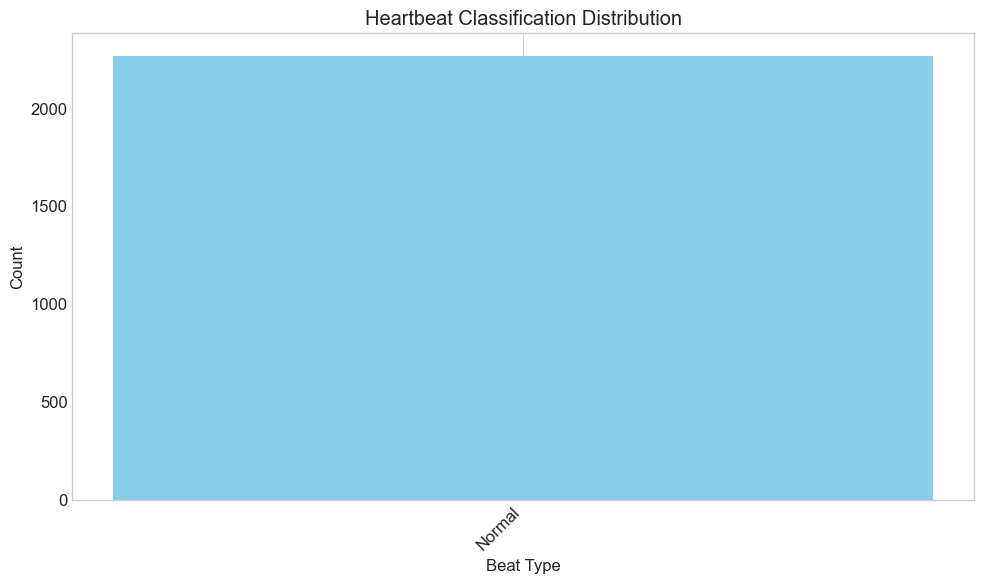

In [6]:

# %% Cell 6: Classify Heartbeats
# Classify heartbeats
class_ids, class_names, probabilities = arrhythmia_classifier.classify_multiple_heartbeats(
    heartbeats, pipeline, feature_extraction, label_names
)

print(f"Classified {len(class_names)} heartbeats")

# Count the number of beats in each class
class_counts = Counter(class_names)
print("\nHeartbeat Classification Results:")
for class_name, count in class_counts.items():
    percentage = count / len(class_names) * 100
    print(f"{class_name}: {count} ({percentage:.1f}%)")

# Plot classification distribution
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title('Heartbeat Classification Distribution')
plt.xlabel('Beat Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

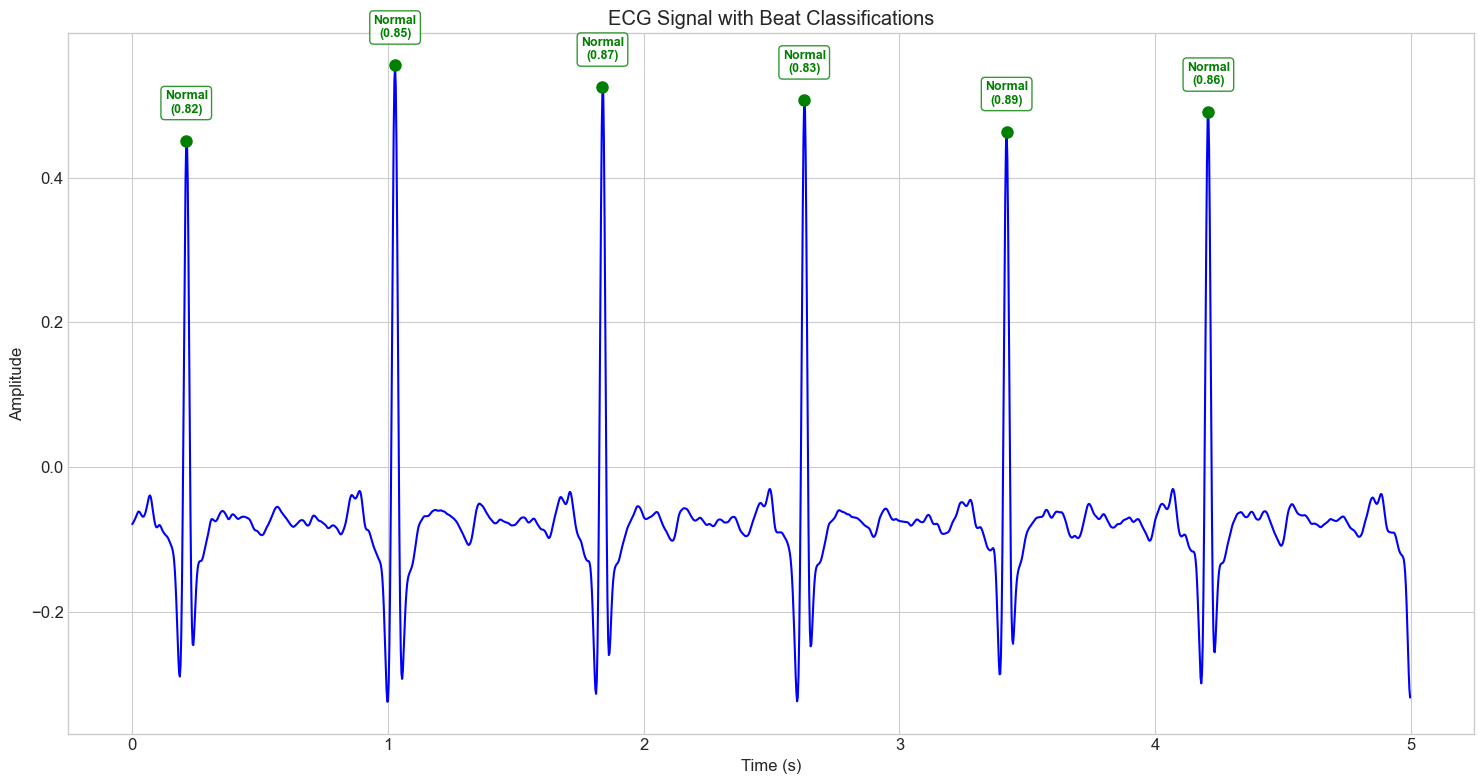

In [7]:
# %% Cell 7: Visualize Classification Results
# Create a color map for different classes
class_colors = {
    'Normal': 'green',
    'Atrial Premature': 'orange',
    'Ventricular Premature': 'red',
    'Fusion': 'purple',
    'Paced': 'brown',
    'Unclassifiable': 'gray'
}

# Define a segment to visualize (5 seconds)
segment_duration = 5  # seconds
segment_start = 0  # seconds
segment_end = segment_start + segment_duration

# Convert to samples
start_sample = int(segment_start * fs)
end_sample = int(segment_end * fs)

# Plot the segment with classifications
plt.figure(figsize=(15, 8))
plt.plot(time[start_sample:end_sample], processed_signal[start_sample:end_sample, channel_to_analyze], 'b-')

# Find R-peaks in the selected window
r_peaks_in_window = r_peaks[(r_peaks >= start_sample) & (r_peaks < end_sample)]

# Mark each R-peak with its classification
for r_peak in r_peaks_in_window:
    # Find the corresponding beat index
    beat_idx = np.where(r_peaks == r_peak)[0][0]
    
    if beat_idx < len(class_names):
        beat_type = class_names[beat_idx]
        confidence = np.max(probabilities[beat_idx]) if probabilities is not None else 1.0
        
        # Use the appropriate color for this beat type
        color = class_colors.get(beat_type, 'black')
        
        # Plot the R-peak
        plt.plot(time[r_peak], processed_signal[r_peak, channel_to_analyze], 'o', 
                color=color, markersize=8)
        
        # Add a label with the beat type and confidence
        plt.annotate(f"{beat_type}\n({confidence:.2f})", 
                    (time[r_peak], processed_signal[r_peak, channel_to_analyze]),
                    xytext=(0, 20), textcoords='offset points', ha='center',
                    color=color, fontsize=9, weight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", fc='white', ec=color, alpha=0.8))

plt.title('ECG Signal with Beat Classifications')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:

# %% Cell 8: Analyze Abnormal Beats
# Identify abnormal beats
normal_beats = [i for i, class_name in enumerate(class_names) if class_name == 'Normal']
abnormal_beats = [i for i, class_name in enumerate(class_names) if class_name != 'Normal']

print(f"Number of normal beats: {len(normal_beats)}")
print(f"Number of abnormal beats: {len(abnormal_beats)}")

# If we have abnormal beats, analyze them
if abnormal_beats:
    # Select a few abnormal beats to analyze
    beats_to_analyze = abnormal_beats[:min(3, len(abnormal_beats))]
    
    plt.figure(figsize=(15, 5 * len(beats_to_analyze)))
    
    for i, beat_idx in enumerate(beats_to_analyze):
        plt.subplot(len(beats_to_analyze), 2, 2*i+1)
        
        # Plot the beat
        beat_time = np.linspace(-0.25, 0.45, heartbeats[beat_idx].shape[0])
        plt.plot(beat_time, heartbeats[beat_idx])
        plt.axvline(x=0, color='r', linestyle='--')
        plt.title(f'Abnormal Beat {i+1}: {class_names[beat_idx]}')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.grid(True)
        
        # Plot the beat's classification probabilities if available
        plt.subplot(len(beats_to_analyze), 2, 2*i+2)
        if probabilities is not None:
            # Get probabilities for this beat
            probs = probabilities[beat_idx]
            
            # Create labels for all classes
            all_classes = list(label_names.values())
            
            # Fill in the available probabilities
            plot_probs = []
            for class_idx in range(len(all_classes)):
                if class_idx < len(probs):
                    plot_probs.append(probs[class_idx])
                else:
                    plot_probs.append(0)
            
            # Create bar chart
            plt.bar(all_classes, plot_probs, color='skyblue')
            plt.title(f'Classification Probabilities')
            plt.xlabel('Beat Type')
            plt.ylabel('Probability')
            plt.ylim(0, 1)
            plt.grid(axis='y')
            plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    # Compare with a normal beat if available
    if normal_beats:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # Plot a normal beat
        normal_idx = normal_beats[0]
        beat_time = np.linspace(-0.25, 0.45, heartbeats[normal_idx].shape[0])
        
        axes[0].plot(beat_time, heartbeats[normal_idx])
        axes[0].axvline(x=0, color='r', linestyle='--')
        axes[0].set_title(f'Normal Beat')
        axes[0].set_xlabel('Time (s)')
        axes[0].set_ylabel('Amplitude')
        axes[0].grid(True)
        
        # Plot an abnormal beat
        abnormal_idx = abnormal_beats[0]
        
        axes[1].plot(beat_time, heartbeats[abnormal_idx])
        axes[1].axvline(x=0, color='r', linestyle='--')
        axes[1].set_title(f'Abnormal Beat: {class_names[abnormal_idx]}')
        axes[1].set_xlabel('Time (s)')
        axes[1].set_ylabel('Amplitude')
        axes[1].grid(True)
        
        plt.tight_layout()
        plt.show()
else:
    print("No abnormal beats detected in this ECG signal.")


Number of normal beats: 2271
Number of abnormal beats: 0
No abnormal beats detected in this ECG signal.


Heart Rate Variability Metrics:
Mean RR Interval: 0.795 s
Standard Deviation of RR Intervals: 0.049 s
RMSSD: 0.063 s


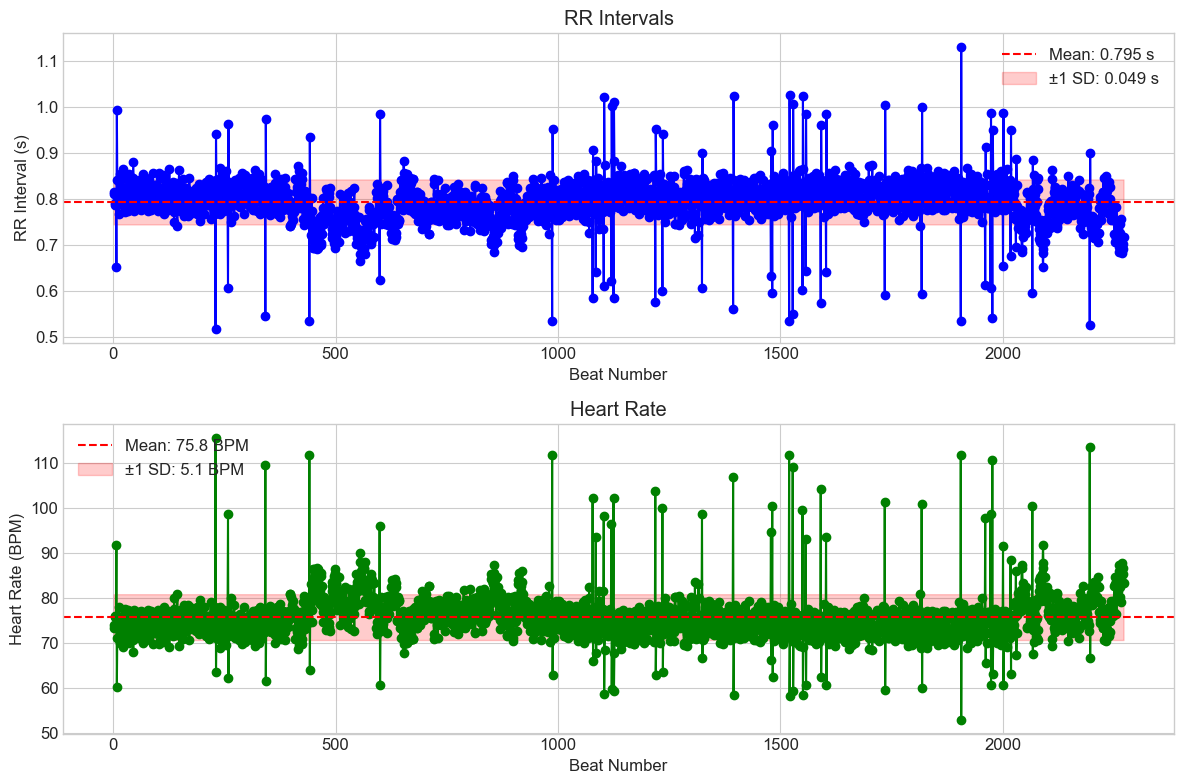

Assessment: Regular heart rhythm (normal RR interval variability)

=== ECG Analysis Report ===
Total beats analyzed: 2273
Average heart rate: 75.5 BPM

Beat Classification Summary:
  Normal: 2271 (100.0%)

Heart Rate Variability:
  Mean RR Interval: 0.795 s
  RR Interval Std Dev: 0.049 s
  RMSSD: 0.063 s

Rhythm Assessment: Regular

Abnormal Beat Analysis:
  No abnormal beats detected

Model Information:
  Classification model used: random_forest


In [9]:

# %% Cell 9: Heart Rate Variability Analysis
if len(r_peaks) > 1:
    # Calculate RR intervals
    rr_intervals = np.diff(r_peaks) / fs  # in seconds
    
    # Calculate heart rate
    heart_rates = 60 / rr_intervals  # in BPM
    
    # Calculate HRV metrics
    mean_rr = np.mean(rr_intervals)
    std_rr = np.std(rr_intervals)
    rmssd = np.sqrt(np.mean(np.diff(rr_intervals) ** 2))  # Root Mean Square of Successive Differences
    
    print("Heart Rate Variability Metrics:")
    print(f"Mean RR Interval: {mean_rr:.3f} s")
    print(f"Standard Deviation of RR Intervals: {std_rr:.3f} s")
    print(f"RMSSD: {rmssd:.3f} s")
    
    # Plot RR intervals and heart rate
    plt.figure(figsize=(12, 8))
    
    # Plot RR intervals
    plt.subplot(2, 1, 1)
    plt.plot(np.arange(1, len(rr_intervals) + 1), rr_intervals, 'b-o')
    plt.axhline(y=mean_rr, color='r', linestyle='--', label=f'Mean: {mean_rr:.3f} s')
    plt.fill_between(np.arange(1, len(rr_intervals) + 1), 
                     mean_rr - std_rr, mean_rr + std_rr, 
                     color='r', alpha=0.2, label=f'±1 SD: {std_rr:.3f} s')
    plt.title('RR Intervals')
    plt.xlabel('Beat Number')
    plt.ylabel('RR Interval (s)')
    plt.legend()
    plt.grid(True)
    
    # Plot heart rate
    plt.subplot(2, 1, 2)
    plt.plot(np.arange(1, len(heart_rates) + 1), heart_rates, 'g-o')
    plt.axhline(y=np.mean(heart_rates), color='r', linestyle='--', 
               label=f'Mean: {np.mean(heart_rates):.1f} BPM')
    plt.fill_between(np.arange(1, len(heart_rates) + 1), 
                     np.mean(heart_rates) - np.std(heart_rates), 
                     np.mean(heart_rates) + np.std(heart_rates), 
                     color='r', alpha=0.2, label=f'±1 SD: {np.std(heart_rates):.1f} BPM')
    plt.title('Heart Rate')
    plt.xlabel('Beat Number')
    plt.ylabel('Heart Rate (BPM)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Rhythm analysis
    if std_rr > 0.1:
        print("Assessment: Irregular heart rhythm (high RR interval variability)")
    else:
        print("Assessment: Regular heart rhythm (normal RR interval variability)")
else:
    print("Not enough beats detected for HRV analysis.")

# %% Cell 10: Generate Analysis Report
print("\n=== ECG Analysis Report ===")
print(f"Total beats analyzed: {len(r_peaks)}")
print(f"Average heart rate: {heart_rate:.1f} BPM")

if len(class_counts) > 0:
    print("\nBeat Classification Summary:")
    for class_name, count in class_counts.items():
        percentage = count / len(class_names) * 100
        print(f"  {class_name}: {count} ({percentage:.1f}%)")

if len(r_peaks) > 1:
    print("\nHeart Rate Variability:")
    print(f"  Mean RR Interval: {mean_rr:.3f} s")
    print(f"  RR Interval Std Dev: {std_rr:.3f} s")
    print(f"  RMSSD: {rmssd:.3f} s")
    
    if std_rr > 0.1:
        print("\nRhythm Assessment: Irregular")
    else:
        print("\nRhythm Assessment: Regular")

print("\nAbnormal Beat Analysis:")
if len(abnormal_beats) > 0:
    print(f"  {len(abnormal_beats)} abnormal beats detected ({len(abnormal_beats)/len(r_peaks)*100:.1f}%)")
    # Group abnormal beats by type
    abnormal_types = Counter([class_names[i] for i in abnormal_beats])
    for abnormal_type, count in abnormal_types.items():
        print(f"  {abnormal_type}: {count}")
else:
    print("  No abnormal beats detected")

print("\nModel Information:")
print(f"  Classification model used: {model_to_use}")
print("===============================")